# NFL BIG DATA BOWL 2020 - 2021

# 0. Introduction
In this notebook we continue on from the 'BDB20-21_EDA_and_cleanup' notebook, which performs the Exploratory Data Analysis, and does some basic data wrangling on this data.  
This notebook focuses on some data visualizations to gain a better understanding on the data, and does some more elaborate feature engineering to create new data points in preparation for a machine learning algorithm

# 1. Notebook preparation
In this section of the notebook we load in all the necessary libraries, we read in the data and perform the data wrangling actions as found necessary in the BDB20-21_EDA_and_cleanup notebook.

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette = 'deep')
import datetime as dt
import time
from datetime import date
from tqdm.notebook import tqdm
import math
import cv2
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
import sys
import ipywidgets as widgets
py.offline.init_notebook_mode(connected=True)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy

ipython_vars = list(globals().keys())

In [2]:
# Load the data
# Import the data contained in individual files
games = pd.read_csv("../Data/games.csv")
players = pd.read_csv("../Data/players.csv")
plays = pd.read_csv("../Data/plays.csv")

# Import the weekly tracking data
weeks = range(1,18)
tracking = pd.DataFrame()
for i in tqdm(weeks):
    week_data = pd.read_csv('../Data/week' + str(i) + '.csv')
    week_data['week'] = i
    tracking = tracking.append(week_data)

In [3]:
# Clean up the games dataset based on EDA notebook
games['gameDateTime'] = games.gameDate + " - " + games.gameTimeEastern
games.gameDateTime = pd.to_datetime(games.gameDateTime, format = '%m/%d/%Y - %H:%M:%S')
games['gameMonth'] = games.gameDateTime.dt.month_name()
games['gameWeekDay'] = games.gameDateTime.dt.day_name()
games['gameHour'] = games.gameDateTime.dt.hour
games['gameTimeSlot'] = np.NaN
games.loc[games.gameHour < 12, 'gameTimeSlot'] = 'Morning'
games.loc[(games.gameHour >=12) & (games.gameHour < 15), 'gameTimeSlot'] = 'Noon'
games.loc[(games.gameHour >=15) & (games.gameHour < 18), 'gameTimeSlot'] = 'Afternoon'
games.loc[games.gameHour >=18, 'gameTimeSlot'] = 'Evening'
games.drop(['gameHour', 'gameDate', 'gameTimeEastern'], axis = 1, inplace = True)
games['week'] = games.week.astype(str)

In [4]:
# Clean up the players dataset based on the EDA notebook
players['nflId'] = players.nflId.astype(str)
players.height = np.where(players.height.str.contains("-"), players.height, "0-" + players.height)
players.height = (players.height.str.split("-").str[0].astype(int) *12) + players.height.str.split("-").str[-1].astype(int)
players['birthDate'] = pd.to_datetime(players.birthDate)
players['age'] = ((pd.to_datetime("09/01/2018", format = "%m/%d/%Y") - 
                  players.birthDate).dt.days/365.25).apply(np.floor).astype(int)

players['consPosition'] = players.position
players.consPosition = players.consPosition.replace('OLB','LB')
players.consPosition = players.consPosition.replace('ILB','LB')
players.consPosition = players.consPosition.replace('MLB','LB')
players.consPosition = players.consPosition.replace('FS','S')
players.consPosition = players.consPosition.replace('SS','S')
players.consPosition = players.consPosition.replace('LS','S')
players.consPosition = players.consPosition.replace('HB','RB')
players.consPosition = players.consPosition.replace('NT','DT')
players.consPosition = players.consPosition.replace('DB','CB')

In [5]:
# Clean up the plays dataset based on the EDA notebook
plays.yardlineSide = plays.yardlineSide.replace(np.NaN, 'Midfield')

plays['offenseQB'] = 0
plays['offenseRB'] = 0
plays['offenseWR'] = 0
plays['offenseTE'] = 0
plays['offenseOL'] = 0
plays['offenseDL'] = 0
plays['offenseDB'] = 0
plays['offenseP'] = 0
plays['offenseLS'] = 0
plays['offenseK'] = 0
plays['offenseLB'] = 0

for i in tqdm(range(0,len(plays))):
    if str(plays.loc[i,'personnelO']) == 'nan':
        plays.loc[i,'offenseRB'] = np.nan
        plays.loc[i,'offenseWR'] = np.nan
        plays.loc[i,'offenseTE'] = np.nan
        plays.loc[i,'offenseQB'] = np.nan
        plays.loc[i,'offenseOL'] = np.nan
        plays.loc[i,'offenseDL'] = np.nan
        plays.loc[i,'offenseDB'] = np.nan
        plays.loc[i,'offenseP'] = np.nan
        plays.loc[i,'offenseLS'] = np.nan
        plays.loc[i,'offenseK'] = np.nan
        plays.loc[i,'offenseLB'] = np.nan
        continue
    personnelO_split = plays.personnelO.loc[i].split(",")
    personnelO_split = [x.strip(' ') for x in personnelO_split]
    for j in personnelO_split:
        if "RB" in j:
            plays.loc[i,'offenseRB'] = int(j[0])
        if "WR" in j:
            plays.loc[i,'offenseWR'] = int(j[0])
        if "TE" in j:
            plays.loc[i,'offenseTE'] = int(j[0])
        if "QB" in j:
            plays.loc[i,'offenseQB'] = int(j[0])
        if "OL" in j:
            plays.loc[i,'offenseOL'] = int(j[0])
        if "DL" in j:
            plays.loc[i,'offenseDL'] = int(j[0])
        if "DB" in j:
            plays.loc[i,'offenseDB'] = int(j[0])
        if "P" in j:
            plays.loc[i,'offenseP'] = int(j[0])
        if "LS" in j:
            plays.loc[i,'offenseLS'] = int(j[0])
        if "K" in j:
            plays.loc[i,'offenseK'] = int(j[0])
        if "LB" in j:
            plays.loc[i,'offenseLB'] = int(j[0])
positions = ['offenseRB', 'offenseWR', 'offenseTE', 'offenseQB', 'offenseOL', 'offenseDL',
            'offenseDB', 'offenseP', 'offenseLS', 'offenseK', 'offenseLB']
plays['positions_summed'] = plays[positions].sum(axis=1)
for i in tqdm(range(0,len(plays))):
    if str(plays.loc[i,'personnelO']) == 'nan':
        continue
    if (("QB" not in plays.personnelO.loc[i]) & (plays.positions_summed.loc[i] < 11) &
       ("K" not in plays.personnelO.loc[i]) & ("P" not in plays.personnelO.loc[i])):
        plays.loc[i,'offenseQB'] = 1
plays['positions_summed'] = plays[positions].sum(axis=1)
for i in tqdm(range(0,len(plays))):
    if str(plays.loc[i,'personnelO']) == 'nan':
        continue
    if (("OL" not in plays.personnelO.loc[i]) & (plays.positions_summed.loc[i] < 11)):
        plays.loc[i,'offenseOL'] = 11 - plays.loc[i,'positions_summed']
plays.drop('positions_summed', axis = 1, inplace = True)   
        
plays['defenseDL'] = 0
plays['defenseLB'] = 0
plays['defenseDB'] = 0
plays['defenseWR'] = 0
plays['defenseOL'] = 0
plays['defenseTE'] = 0
plays['defenseRB'] = 0
plays['defenseQB'] = 0
for i in tqdm(range(0,len(plays))):
    if str(plays.personnelD.loc[i]) == 'nan':
        plays.loc[i,'defenseDL'] = np.nan
        plays.loc[i,'defenseLB'] = np.nan
        plays.loc[i,'defenseDB'] = np.nan
        plays.loc[i,'defenseWR'] = np.nan
        plays.loc[i,'defenseOL'] = np.nan
        plays.loc[i,'defenseTE'] = np.nan
        plays.loc[i,'defenseRB'] = np.nan
        plays.loc[i,'defenseQB'] = np.nan
        continue
    personnelD_split = plays.personnelD.loc[i].split(",")
    personnelD_split = [x.strip(' ') for x in personnelD_split]
    for j in personnelD_split:
        if "DL" in j:
            plays.loc[i,'defenseDL'] = float(j[0])
        if "LB" in j:
            plays.loc[i,'defenseLB'] = float(j[0])
        if "DB" in j:
            plays.loc[i,'defenseDB'] = float(j[0])
        if "WR" in j:
            plays.loc[i,'defenseWR'] = float(j[0])
        if "OL" in j:
            plays.loc[i,'defenseOL'] = float(j[0])
        if "TE" in j:
            plays.loc[i,'defenseTE'] = float(j[0])
        if "RB" in j:
            plays.loc[i,'defenseRB'] = float(j[0])
        if "QB" in j:
            plays.loc[i,'defenseQB'] = float(j[0])
      
plays['gameClock_minutes'] = plays.gameClock.str.split(":").str[0].astype(float)
plays['gameClock_seconds'] = plays.gameClock.str.split(":").str[1].astype(float)
plays['secondsInQuarter'] = plays.gameClock_minutes * 60 + plays.gameClock_seconds
plays.drop(['gameClock_minutes', 'gameClock_seconds'], axis = 1, inplace = True)

plays['quarter_reversed'] = (plays.quarter - 4) * (-1)
plays['secondsInGame'] = plays.quarter_reversed * 900 + plays.secondsInQuarter
plays[plays['secondsInGame'] < 0].secondsInGame = np.NaN
plays.drop('quarter_reversed', axis = 1, inplace = True)

plays.absoluteYardlineNumber = plays.absoluteYardlineNumber - 10


penalties = plays.penaltyCodes.str.split(";", expand=True).stack().str.get_dummies().sum(level=0)
penalties = penalties[['DPI','OPI','ICT','DH']].copy()
plays = plays.join(penalties)
plays[['DPI','OPI','ICT','DH']] = plays[['DPI','OPI','ICT','DH']].fillna(0)
plays.ICT = plays.ICT.astype(str).replace("2.0","1.0").astype(float)
plays.DH = plays.DH.astype(str).replace("2.0","1.0").astype(float)
plays.drop('penaltyCodes', axis = 1, inplace = True)

plays.drop('penaltyJerseyNumbers', axis = 1, inplace = True)

plays = plays[plays['passResult'] != 'R'].reset_index(drop=True)

plays['uniquePlay'] = plays['gameId'].astype(str) + '_' + plays['playId'].astype(str)

/Users/rubenb/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [6]:
# Clean tracking dataset based on the EDA notebook
tracking.time = pd.to_datetime(tracking.time, format = '%Y-%m-%dT%H:%M:%S.%f')

tracking = tracking.drop(tracking[(tracking['gameId'] == 2018102101) & (tracking['playId'] == 3078)].index)
plays = plays.drop(plays[(plays['gameId'] == 2018102101) & (plays['playId'] == 3078)].index)

tracking['s'].at[18040204] = 2.74

tracking = tracking.drop(tracking[(tracking['gameId'] == 2018091602) & (tracking['playId'] == 3122)].index)
plays = plays.drop(plays[(plays['gameId'] == 2018091602) & (plays['playId'] == 3122)].index)

tracking.a.at[18040204] = 2.43

tracking.drop('jerseyNumber', axis = 1, inplace = True)

tracking['consPosition'] = tracking.position
tracking.consPosition = tracking.consPosition.replace('OLB','LB')
tracking.consPosition = tracking.consPosition.replace('ILB','LB')
tracking.consPosition = tracking.consPosition.replace('MLB','LB')
tracking.consPosition = tracking.consPosition.replace('FS','S')
tracking.consPosition = tracking.consPosition.replace('SS','S')
tracking.consPosition = tracking.consPosition.replace('LS','S')
tracking.consPosition = tracking.consPosition.replace('HB','RB')
tracking.consPosition = tracking.consPosition.replace('NT','DT')
tracking.consPosition = tracking.consPosition.replace('DB','CB')
tracking.drop('position', axis = 1, inplace = True)

tracking['uniqueFrame'] = tracking['gameId'].astype(str) + '_' + tracking['playId'].astype(str) + '_' + tracking['frameId'].astype(str)
tracking['uniquePlay'] = tracking['gameId'].astype(str) + '_' + tracking['playId'].astype(str)

print("1. Finished initial cleaning")

trick_events = ['qb_spike', 'punt_fake', 'field_goal_fake', 'field_goal_blocked', 'field_goal_play']
plays_to_remove = tracking[tracking['event'].isin(trick_events)].uniquePlay.unique()
tracking = tracking[~tracking['uniquePlay'].isin(plays_to_remove)]
plays = plays[~plays['uniquePlay'].isin(plays_to_remove)]

print("2. Removed trick plays")

multi_event_frames = tracking[['uniqueFrame','event']].groupby(by = 'uniqueFrame').nunique()
multi_event_frames = multi_event_frames[multi_event_frames['event'] > 1]
multi_event_frames = list(multi_event_frames.index)
multi_event_frames_count = tracking[tracking['uniqueFrame'].isin(multi_event_frames)][['uniquePlay','uniqueFrame','event','time']].groupby(by = ['uniquePlay','uniqueFrame','event']).count()
multi_event_plays = list(multi_event_frames_count.index.unique(level = 'uniquePlay'))
tracking = tracking[~tracking['uniquePlay'].isin(multi_event_plays)]
plays = plays[~plays['uniquePlay'].isin(multi_event_plays)]

print("3. Removed multi event frames")

time_values_check = tracking.groupby(by = ['gameId', 'uniquePlay', 'uniqueFrame', 'frameId']).agg({'time': ['min','max']}).reset_index()
time_values_check.columns = [' '.join(col).strip() for col in time_values_check.columns.values]
time_values_check['differential'] = time_values_check['time max'] - time_values_check['time min']
time_values_check['differential'] = time_values_check['differential'].astype('timedelta64[s]')
plays_to_validate = time_values_check[time_values_check['differential'] > 0].reset_index(drop = True)
events = ['pass_arrived', 'pass_outcome_caught', 'tackle', 'pass_outcome_incomplete', 'out_of_bounds', 'qb_sack',
          'touchdown', 'pass_outcome_touchdown', 'pass_outcome_interception', 'fumble', 'qb_strip_sack',
          'fumble_defense_recovered', 'fumble_offense_recovered', 'qb_spike']
plays_to_remove = []
frames_to_remove = []
for i in tqdm(plays_to_validate.uniquePlay.unique()):
    smallest_frame = plays_to_validate[plays_to_validate['uniquePlay'] == str(i)].frameId.min()
    largest_frame = plays_to_validate[plays_to_validate['uniquePlay'] == str(i)].frameId.max()
    play_data = tracking[tracking['uniquePlay'] == str(i)]
    largest_overall_frame = play_data.frameId.max()
    if largest_frame < largest_overall_frame:
        plays_to_remove.append(play_data.uniquePlay.iloc[0])
    else:
        problem_frames = play_data[play_data['frameId'] >= smallest_frame]
        
        if problem_frames.event.isin(events).any():
            plays_to_remove.append(problem_frames.uniquePlay.iloc[0])
        else:
            for j in problem_frames.uniqueFrame.unique():
                frames_to_remove.append(j)
tracking = tracking[~tracking['uniqueFrame'].isin(frames_to_remove)]
tracking = tracking[~tracking['uniquePlay'].isin(plays_to_remove)]
plays = plays[~plays['uniquePlay'].isin(plays_to_remove)]

print("4. Removed distorted time sequences")

time_diffs = tracking[['time', 'gameId', 'playId', 'frameId']].drop_duplicates().reset_index(drop = True)
time_diffs['time_diff'] = time_diffs['time'].diff()
time_diffs['time_diff'] = time_diffs['time_diff'].dt.total_seconds()
time_diffs['time_diff'] = np.where((time_diffs.gameId != time_diffs.gameId.shift(1)) |
                                   (time_diffs.playId != time_diffs.playId.shift(1)),
                                  np.NaN, time_diffs.time_diff)
time_diffs.drop('time', axis = 1, inplace = True)
problem_data = time_diffs[(time_diffs['time_diff'] < 0.08) |
                          (time_diffs['time_diff'] > 0.12)]
problem_data['uniquePlay'] = problem_data['gameId'].astype(str) + '_' + problem_data['playId'].astype(str)
problem_data.groupby(by = 'uniquePlay').count()
plays_to_remove = list(problem_data.uniquePlay.unique())
tracking = tracking[~tracking['uniquePlay'].isin(plays_to_remove)]
plays = plays[~plays['uniquePlay'].isin(plays_to_remove)]
tracking[tracking['frameId'] == 1].dis = np.NaN

print("5. Removed distorted time sequences")

tracking.drop_duplicates(inplace = True)

print("6. Remove duplicate records")

tracking = tracking.merge(games[['gameId','homeTeamAbbr','visitorTeamAbbr']],how = 'left',on = 'gameId')
tracking = tracking.merge(plays[['gameId','playId','absoluteYardlineNumber','possessionTeam']],how = 'left',on = ['gameId','playId'])
tracking['side'] = np.NaN
tracking['side'] = np.where(tracking['team'] == 'football','football',tracking['side'])
tracking['side'] = np.where((tracking['team'] == 'home') & (tracking['homeTeamAbbr'] == tracking['possessionTeam']),'offense',tracking['side'])
tracking['side'] = np.where((tracking['team'] == 'home') & (tracking['visitorTeamAbbr'] == tracking['possessionTeam']),'defense',tracking['side'])
tracking['side'] = np.where((tracking['team'] == 'away') & (tracking['homeTeamAbbr'] == tracking['possessionTeam']),'defense',tracking['side'])
tracking['side'] = np.where((tracking['team'] == 'away') & (tracking['visitorTeamAbbr'] == tracking['possessionTeam']),'offense',tracking['side'])

print("7. Tracking data cleansing completed")

1. Finished initial cleaning
2. Removed trick plays
3. Removed multi event frames



4. Removed distorted time sequences


/Users/rubenb/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/rubenb/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5. Removed distorted time sequences
6. Remove duplicate records
7. Tracking data cleansing completed


In [7]:
del week_data, time_values_check, time_diffs, problem_data, play_data, penalties, multi_event_frames_count,
del plays_to_validate, problem_frames, plays_to_remove, multi_event_plays, events, positions, trick_events
del personnelD_split, personnelO_split, j, i, weeks, largest_frame, largest_overall_frame, smallest_frame

In [8]:
# Function to plot data labels to scatterplots
def set_labels(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.3, point['y']+.3, str(point['val']))

In [9]:
# Function to plot positions at a particular event on the field
# Valid event choices are: snap; pass; pass_arrived; pass_caught; tackle; contact; pass_cinomplete; play_action;
# out_of_bounds; line_set; sack; first; last

def plot_event_positions(event, gameId = 2018090600, playId = 75):
    # Set the event labels
    event_labels = {'snap':'ball_snap', 'pass':'pass_forward', 'pass_arrived':'pass_arrived',
                'pass_caught':'pass_outcome_caught', 'tackle':'tackle', 'contact':'first_contact',
                'pass_incomplete':'pass_outcome_incomplete', 'play_action':'play_action',
                'out_of_bounds':'out_of_bounds', 'line_set':'line_set', 'sack':'qb_sack'
                }
    
    # First we filter out the necessary data
    # We start by filtering out the relevant game and play data
    example_play = tracking[(tracking['gameId'] == gameId) & 
                            (tracking['playId'] == playId)]
    # Then we filter out the correct event
    if event == 'first':
        example_play = example_play[example_play['frameId'] == 1]
    elif event == 'last':
        example_play = example_play[example_play['frameId'] == max(example_play['frameId'])]
    elif event in event_labels.keys():
        if event_labels[event] in list(example_play.event):
            example_play = example_play[example_play['event'] == event_labels[event]]
        else:
            return(print('The selected event does not occur in the selected play'))
    else:
        return(print('The selected event is not valid'))
    example_play.reset_index(drop=True, inplace = True)
    
    # Set the line of scrimmage
    LOS = example_play.absoluteYardlineNumber[0] + 10
    
    # Next we use seaborn to create a scatterplot of the data
    fig, ax = plt.subplots(figsize = (14.4, 6.4))
    g = sns.scatterplot(data = example_play
                       , x = 'x', y = 'y'
                       , hue = 'side' # Do we need this if we also set style?
                       , s = 200
                       , style = 'side'
                       , markers = {'offense': 'X', 'defense':'o', 'football':'D'}
                       )
    plt.axvline(x = LOS, lw = 4, c = 'red')
    # Set the size of the plot to include the full football field
    g.set(xlim=(0,120))
    g.set(ylim=(0,53.3))
    
    # Use our custom set_labels function to assign labels to the markers
    set_labels(example_play.x, example_play.y, example_play.consPosition, plt.gca())
    
    # Add the picture of the football field to the background
    ### NOTE: THE ASSIGNMENT REQUIRES THAT NO EXTERNAL DATA IS ADDED, SO THIS WILL NEED
    ### TO BE REPLACED BY A WAY OF SHOWING THE FOOTBALL FIELD WITHOUT AN IMPORTED IMAGE
    with open('../Resources/football_field.png', 'rb') as file:
        img = plt.imread(file, 'PNG')
    plt.imshow(img, zorder = 0, extent = [0.0, 120.0, 0.00, 53.3])

In [10]:
# Function to plot routes on the field
def plot_routes(gameId = 2018090600, playId = 75):
    # First we filter out the necessary data
    # This means getting the data for the game and play
    example_play = tracking[(tracking['gameId'] == gameId) &
                            (tracking['playId'] == playId)
                           ]
    example_play.reset_index(drop = True, inplace = True)
    
    # Set the line of scrimmage
    LOS = example_play.absoluteYardlineNumber[0] + 10
    
    # Next we use plotly to create a scatterplot for the data where each player and ball is traced.
    # Initiate the plotting
    fig = go.Figure()
    
    # Add the offense players traces
    for i in pd.unique(example_play[example_play['side'] == 'offense'].nflId):
        fig.add_trace(go.Scatter(x = example_play[example_play['nflId'] == i].x
                                , y = example_play[example_play['nflId'] == i].y
                                , name = example_play[example_play['nflId'] == i].displayName.iloc[0]
                                , mode = 'lines+markers'
                                , marker_color = 'rgba(83, 51, 237, 1)'
                                )
                     )
        
    # Add the defensive players traces
    for i in pd.unique(example_play[example_play['side'] == 'defense'].nflId):
        fig.add_trace(go.Scatter(x = example_play[example_play['nflId'] == i].x
                                , y = example_play[example_play['nflId'] == i].y
                                , name = example_play[example_play['nflId'] == i].displayName.iloc[0]
                                , mode = 'lines+markers'
                                , marker_color = 'rgba(242, 38, 19, 1)'
                                )
                     )
        
    # Add the football trace
    fig.add_trace(go.Scatter(x = example_play[example_play['nflId'].isnull()].x
                            , y = example_play[example_play['nflId'].isnull()].y
                            , name = 'football'
                            , mode = 'lines+markers'
                            , marker_color = 'rgba(240, 255, 0, 1)'
                            )
                 )
    
    # Add the line of scrimmage
    fig.add_trace(go.Scatter(x = [LOS, LOS]
                            , y = [0, 53.3]
                            , name = 'line of scrimmage'
                            , mode = 'lines'
                            , line = dict(
                                color = 'rgba(255, 0, 0, 1)'
                                , width = 4
                                )
                            )
                 )
    
    # Set the axes of the plot to include the full football field
    fig.update_xaxes(range = [0, 120])
    fig.update_yaxes(range = [0, 53.3])
    
    # Add the background image of a football field
    ### NOTE: THE ASSIGNMENT REQUIRES THAT NO EXTERNAL DATA IS ADDED, SO THIS WILL NEED
    ### TO BE REPLACED BY A WAY OF SHOWING THE FOOTBALL FIELD WITHOUT AN IMPORTED IMAGE
    fig.add_layout_image(
        dict(
            source="../Resources/football_field.png"
            , xref="x"
            , yref="y"
            , x=0
            , y=53.3
            , sizex=120
            , sizey=53.3
            , sizing="stretch"
            , opacity=0.8
            , layer="below"
        )
    )
    
    # Show the plot
    fig.show()

# 2. Feature engineering
In this paragraph we build out our data set that we will use to build a model.  
We also introduce a number of new variables that could help our model accuracy.

## 2.1. Building base dataset
The value we are trying to predict is the outcome of a pass for each play.  
This immediately implies that the granularity of our data is at the play level, so the plays dataset is going to be the basis for our data.  
We do have a few options on how to shape our target variable for analysis:
* We could shape our data into a binomial target variable. This means that each play is marked as either a complete or incomplete pass. Within this approach we have a secondary decision on how to treat QB sacks:
    - Either sacks are considered to be incomplete passes
    - Or sacks are eliminated from the dataset for analysis
* We could also shape our target variable into 3 distinct values:
    - Value 1 is assigned to a completed pass
    - Value 0 is assigned to an incomplete pass
    - Value -1 is assigned to a QB sack or interception
* We could make the target variable even more granular by introducing the result of the play as a touchdown or not:
    - Value 2 is assigned to a completed pass resulting in a touchdown
    - Value 1 is assigned to a completed pass not resulting in a touchdown
    - Value 0 is assigned to an incomplete pass
    - Value -1 is assigned to a QB sack
    - Value -2 is assigned to an interception
* Finally, for the best estimate of how positive a play outcome is for the offensive team, we could use the total amount of yards gained as the target variable. Optionally, we could add an arbitrary number of yards (e.g.: 100) to this for plays resulting in a touchdown.

For the time being we start with the simplest target variable: A binomial target (complete vs incomplete) where we eliminate QB sacks from the dataset.

In [11]:
data = plays[['down', 'yardsToGo', 'offenseFormation', 'defendersInTheBox', 'numberOfPassRushers', 'typeDropback',
              'preSnapVisitorScore', 'preSnapHomeScore', 'absoluteYardlineNumber', 'passResult', 'epa', 'offenseQB',
              'offenseRB', 'offenseWR', 'offenseTE', 'offenseOL', 'defenseDL', 'defenseLB', 'defenseDB',
              'secondsInGame', 'DPI', 'OPI', 'ICT', 'DH', 'uniquePlay']]

In [12]:
data = data[data['passResult'] != 'S'].reset_index(drop = True)

In [13]:
data['target'] = np.where(data['passResult'] == 'C', 1, 0)
data.drop('passResult', axis = 1, inplace = True)

In [14]:
data.head()

,down,yardsToGo,offenseFormation,defendersInTheBox,numberOfPassRushers,typeDropback,preSnapVisitorScore,preSnapHomeScore,absoluteYardlineNumber,epa,...,defenseDL,defenseLB,defenseDB,secondsInGame,DPI,OPI,ICT,DH,uniquePlay,target
0,1,15,I_FORM,7.0,4.0,TRADITIONAL,0.0,0.0,80.0,0.261827,...,4.0,2.0,5.0,3600.0,0.0,0.0,0.0,0.0,2018090600_75,1
1,1,10,SINGLEBACK,7.0,4.0,TRADITIONAL,0.0,0.0,39.0,-0.372360,...,4.0,2.0,5.0,3490.0,0.0,0.0,0.0,0.0,2018090600_146,0
2,2,10,SHOTGUN,6.0,4.0,TRADITIONAL,0.0,0.0,39.0,-0.702779,...,4.0,2.0,5.0,3485.0,0.0,0.0,0.0,0.0,2018090600_168,0
3,3,10,SHOTGUN,6.0,5.0,SCRAMBLE_ROLLOUT_LEFT,0.0,0.0,39.0,3.047530,...,4.0,1.0,6.0,3481.0,0.0,0.0,0.0,0.0,2018090600_190,1
4,3,1,SHOTGUN,8.0,6.0,TRADITIONAL,0.0,0.0,1.0,-0.842272,...,6.0,3.0,2.0,3359.0,0.0,0.0,0.0,0.0,2018090600_256,0


## 2.2. Identifying the (intended) receiver and closest defenders
In this paragraph we will use the tracking data to identify for each play who the intended receiver is and who the closest defender is.  
Unfortunately the tracking data does not contain information about which player receives the football or is the intended receiver of the football. So in order to determine the (intended) receiver, we need to look at the proximity of offensive players to the football at the moment the ball is caught or falls incomplete.  
There are a few drawbacks to this approach:
1. If a pass is incomplete when two offensive players are on a straight line from the QB, this approach will assume that the player closest to the football when it falls incomplete, is the intended receiver. However, this might not always match the intention of the QB.
2. If a pass is tipped or deflected, it might fall incomplete closer to an offensive player that was not the intended receiver. In this case this approach will identify the wrong intended receiver.
3. If a QB throws the ball intentionally out of bounds or otherwise incomplete, our approach cannot recognize this, and will mark the receiver closest by as the intended receiver.

Once we identify the intended receiver (keeping in mind the above limitations), we use the distance from the intended receiver to the defensive players in the same frame used to identify the receiver, to identify the closest defender(s) on defense.

### 2.2.1. Finding the most appropriate frame in each play
To find the closest receiver to the ball, we need to first identify the most relevant frame for each play in the tracking data. We can use the event variable to do this:
- For completed passes, we can use the following events: pass_outcome_caught, pass_outcome_touchdown
- For incomplete passes, we can use the following events: pass_outcome_incomplete, pass_outcome_interception

Note that there is a 'pass_tipped' event that occurs in some of our frames. This might be helpful in eliminating mistakes when identifying the intended receiver.  
We first plot out the positions at some events for a few specific plays, to better understand the data and the different events.

In [15]:
#We find out which plays have the events we're interested in
events = ['pass_outcome_caught', 'pass_outcome_touchdown', 'pass_outcome_incomplete', 'pass_outcome_interception']
tracking_events = tracking[tracking['event'].isin(events)]
tracking_events = tracking_events.groupby(by = ['event','uniquePlay','frameId']).count().reset_index()[['event','uniquePlay','frameId']]
tracking_events

,event,uniquePlay,frameId
0,pass_outcome_caught,2018090600_1037,60
1,pass_outcome_caught,2018090600_1061,50
2,pass_outcome_caught,2018090600_1085,53
3,pass_outcome_caught,2018090600_1202,51
4,pass_outcome_caught,2018090600_1344,60
...,...,...,...
17124,pass_outcome_touchdown,2018123014_211,57
17125,pass_outcome_touchdown,2018123014_2203,50
17126,pass_outcome_touchdown,2018123014_2776,68
17127,pass_outcome_touchdown,2018123014_3280,64


In [16]:
duplicate_event_plays = tracking_events.groupby(by = 'uniquePlay').count().reset_index().sort_values(by = 'event', ascending = False)
duplicate_event_plays[duplicate_event_plays['event'] > 1]

,uniquePlay,event,frameId
1515,2018091606_4196,4,4
3676,2018093006_2573,2,2
2955,2018092312_3778,2,2
14275,2018121600_2679,2,2
11539,2018112506_4120,2,2
12931,2018120300_3296,2,2
14596,2018121605_3663,2,2
2169,2018092300_3028,2,2
92,2018090900_2037,2,2
10280,2018111802_3393,2,2


The above analysis shows that there are 13 plays in which we have multiple instances of a pass outcome. We can assume that these are plays where multiple passes occured, where maximum 1 pass was a forward pass.  
We can plot a few of these plays to confirm our expectation.

In [17]:
plot_routes(gameId = 2018091606, playId = 4196)

In [18]:
plot_routes(gameId = 2018112507, playId = 763)

In [19]:
plot_routes(gameId = 2018112506, playId = 4120)

In [20]:
plot_routes(gameId = 2018092300, playId = 3028)

Looking at some of the plots, as well as at some of the footage of these plays (through highlights on YouTube or through NFL GamePass), we can see that some plays are indeed plays including lateral passes. However, we also see some plays where there is only one forward pass, that have multiple pass outcome events throughout the frames.  
To continue the analysis, we decide to remove all of the complete plays where we see this issue occur. In the future, we could reintroduce some of these plays by analyzing exactly the issue with the events, and only taking into account the frame with the outcome of the forward pass for our analysis. However, at this point this would be a lot of manual review for only a small number of plays.

In [21]:
plays_to_remove = list(duplicate_event_plays[duplicate_event_plays['event'] > 1].uniquePlay)
data = data[~data['uniquePlay'].isin(plays_to_remove)]
tracking = tracking[~tracking['uniquePlay'].isin(plays_to_remove)]

In [22]:
del tracking_events, duplicate_event_plays, plays_to_remove, set_labels

### 2.2.2. Eliminate plays where the critical event frame is missing data
Some frames in the tracking dataframe do not include records for all players or the football. If a frame is the critical event frame that is set as the moment the ball is (not) caught, we need to make sure it has a record for all players and the football. If this is not the case, we might be identifying the wrong receiver as the intended receiver, or the wrong defender as the closest defender.  
In this paragraph, we assume that the maximum number of records in a tracking frame, is the desired number of records for all the frames of that play. This implies that we assume there are no redundant or duplicate records in any of the frames in the tracking data.  
Working with this assumption, we can validate that the critical event frame in our tracking dataset for a particular play, has the maximum number of records across all the frames for that play. If this is not the case, we eliminate that play from our further analysis.  
Additionally, we eliminate every play for which the critical event frame does not contain a record for the football.

In [23]:
# Identify plays with inconsistent row count
inconsistent_rows = tracking.groupby(by= ['uniquePlay','uniqueFrame','event'])['playId'].agg(['count']).reset_index(drop = False)
inconsistent_rows = inconsistent_rows.groupby(by = ['uniquePlay','event'])['count'].agg(['min','max']).reset_index(drop = False)

In [24]:
# Remove plays with inconsistent row count
plays_to_remove = list(inconsistent_rows[inconsistent_rows['min'] != inconsistent_rows['max']]['uniquePlay'])
data = data[~data['uniquePlay'].isin(plays_to_remove)]
tracking = tracking[~tracking['uniquePlay'].isin(plays_to_remove)]

In [25]:
# Identify plays with missing football records
with_football = tracking.groupby(by = ['uniquePlay', 'uniqueFrame', 'side'])['playId'].agg(['count']).reset_index(drop = False)
with_football = list(with_football[with_football['side'] == 'football'].uniquePlay.unique())
all_plays = list(tracking.uniquePlay.unique())

In [26]:
# Remove plays with missing football records
plays_to_remove = list(np.setdiff1d(all_plays, with_football, assume_unique = True))
data = data[~data['uniquePlay'].isin(plays_to_remove)]
tracking = tracking[~tracking['uniquePlay'].isin(plays_to_remove)]

### 2.2.2. Calculate distance to football for each player

Now that we know that each play in our dataset has only 1 pass outcome event, we can determine for each player in each frame the distance to the football.

In [27]:
# First we split up the tracking data between player and football records
tracking_players = tracking[tracking['side'] != 'football']
tracking_football = tracking[tracking['side'] == 'football']

In [28]:
# Next we merge the football coordinates to the player tracking coordinates
tracking_players = tracking_players.merge(tracking_football[['x','y','uniqueFrame']],
                                          on = 'uniqueFrame',
                                          how = 'left',
                                          suffixes = ('_player', '_football'))

In [29]:
# Calculate the distance to the football for each player record
tracking_players['yardsToFootball'] = np.sqrt((tracking_players.x_player - tracking_players.x_football)**2 + (tracking_players.y_player - tracking_players.y_football)**2)

### 2.2.3. Identify the intended receiver and get player data
Now that we know the distance to the football for each player in each frame, we can identify the offensive player the closest to the football at the moment the ball is caught. We can then merge in the data from the players dataset about the intended receiver.

In [30]:
intended_receiver = tracking_players[(tracking_players['event'].isin(events)) & (tracking_players['side'] == 'offense')]
intended_receiver = intended_receiver.loc[intended_receiver.groupby('uniquePlay').yardsToFootball.idxmin()]

In [31]:
data = data.merge(intended_receiver[['uniquePlay', 'nflId','x_player','y_player','s','a','dis','o','dir','consPosition','route']],
                 on = 'uniquePlay',
                 how = 'left')
data.rename({'nflId':'intendedReceiver',
             'x_player':'receiver_x',
             'y_player':'receiver_y',
             's':'receiver_s',
             'a':'receiver_a',
             'dis':'receiver_dis',
             'o':'receiver_o',
             'dir':'receiver_dir',
             'consPosition':'receiver_position',
             'route':'receiver_route'},
            inplace = True, axis = 1)

In [32]:
print("There are", len(data[data['intendedReceiver'].isnull()]), "records with a missing intended receiver.")
data[data['intendedReceiver'].isnull()].head()

There are 51 records with a missing intended receiver.


,down,yardsToGo,offenseFormation,defendersInTheBox,numberOfPassRushers,typeDropback,preSnapVisitorScore,preSnapHomeScore,absoluteYardlineNumber,epa,...,intendedReceiver,receiver_x,receiver_y,receiver_s,receiver_a,receiver_dis,receiver_o,receiver_dir,receiver_position,receiver_route
483,2,6,SHOTGUN,7.0,4.0,TRADITIONAL,13.0,9.0,15.0,1.523136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
613,2,9,SHOTGUN,6.0,4.0,TRADITIONAL,21.0,0.0,47.0,-0.321759,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
659,3,2,SHOTGUN,6.0,4.0,TRADITIONAL,0.0,0.0,73.0,1.012291,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
689,1,10,SHOTGUN,6.0,4.0,TRADITIONAL,0.0,16.0,61.0,-0.166626,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
709,2,8,SHOTGUN,6.0,3.0,TRADITIONAL,7.0,0.0,66.0,2.549405,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Since there are some plays where we didn't find an intended receiver, we choose for now to drop these plays from the data. Note that these plays likely don't have an intended receiver because the play in the tracking data didn't contain the right event. We could reintroduce the data into the dataset by reevaluating which events are relevant. We keep this as a potential improvement for later on.

In [33]:
plays_to_remove = list(data[data['intendedReceiver'].isnull()].uniquePlay)
data = data[~data['uniquePlay'].isin(plays_to_remove)]
tracking = tracking[~tracking['uniquePlay'].isin(plays_to_remove)]

In [34]:
data.intendedReceiver = data.intendedReceiver.astype(int).astype(str)
data = data.merge(players[['nflId','height','weight','age']],
                  left_on = 'intendedReceiver',
                  right_on = 'nflId',
                  how = 'left')
data.rename({'height':'receiverHeight',
             'weight':'receiverWeight',
             'age':'receiverAge'},
            axis = 1, inplace = True)
data.drop('nflId', axis = 1, inplace = True)

In [35]:
data.head()

,down,yardsToGo,offenseFormation,defendersInTheBox,numberOfPassRushers,typeDropback,preSnapVisitorScore,preSnapHomeScore,absoluteYardlineNumber,epa,...,receiver_s,receiver_a,receiver_dis,receiver_o,receiver_dir,receiver_position,receiver_route,receiverHeight,receiverWeight,receiverAge
0,1,15,I_FORM,7.0,4.0,TRADITIONAL,0.0,0.0,80.0,0.261827,...,4.93,3.07,0.49,326.77,358.86,WR,HITCH,75,220,29
1,1,10,SINGLEBACK,7.0,4.0,TRADITIONAL,0.0,0.0,39.0,-0.372360,...,5.31,1.96,0.52,96.49,1.37,WR,CROSS,70,192,26
2,2,10,SHOTGUN,6.0,4.0,TRADITIONAL,0.0,0.0,39.0,-0.702779,...,2.42,1.68,0.24,165.04,142.56,RB,SCREEN,68,206,26
3,3,10,SHOTGUN,6.0,5.0,SCRAMBLE_ROLLOUT_LEFT,0.0,0.0,39.0,3.047530,...,7.57,2.57,0.78,165.15,228.30,WR,CORNER,75,220,29
4,3,1,SHOTGUN,8.0,6.0,TRADITIONAL,0.0,0.0,1.0,-0.842272,...,4.70,4.12,0.49,146.27,5.55,RB,OUT,68,206,26


### 2.2.4. Identify closest defender and get player data
Next we identify the closest defender to the intended receiver and fetch the data on them.  
Note that there are 2 ways we could go about calculating the closest defender:
* We could calculate the distance from the intended receiver to the defenders and find the closest one.
* We could calculate the distance from the football to the defenders and find the closest one.

There are pros and cons to each of these approaches, but for the purpose of this analysis, we decide to calculate the proximity to the intended receiver. The reason we decide to go with this approach, is because a ball could fall incomplete close to a certain defender, while another defender was closer to the intended receiver and has deflected or defended the ball.  
As a future improvement to this model, we could try to calculate the closest defender based on their proximity to the football, to see if this increases the model accuracy.


In [36]:
closest_defender = tracking[(tracking['side'] == 'defense') & (tracking['event'].isin(events))]
closest_defender = closest_defender.merge(data[['uniquePlay','intendedReceiver']],
                                          on = 'uniquePlay',
                                          how = 'left')
closest_defender.head()

,time,x,y,s,a,dis,o,dir,event,nflId,...,week,consPosition,uniqueFrame,uniquePlay,homeTeamAbbr,visitorTeamAbbr,absoluteYardlineNumber,possessionTeam,side,intendedReceiver
0,2018-09-07 01:07:19.700000+00:00,81.74,49.08,7.94,2.37,0.80,0.01,347.39,pass_outcome_caught,79848.0,...,1,S,2018090600_75_52,2018090600_75,PHI,ATL,80.0,ATL,defense,2495454
1,2018-09-07 01:07:19.700000+00:00,81.41,19.08,4.65,2.84,0.46,355.18,325.16,pass_outcome_caught,2495613.0,...,1,S,2018090600_75_52,2018090600_75,PHI,ATL,80.0,ATL,defense,2495454
2,2018-09-07 01:07:19.700000+00:00,71.81,37.93,6.57,1.61,0.66,21.37,24.91,pass_outcome_caught,2534832.0,...,1,S,2018090600_75_52,2018090600_75,PHI,ATL,80.0,ATL,defense,2495454
3,2018-09-07 01:07:19.700000+00:00,81.51,39.01,5.58,0.92,0.56,348.97,335.03,pass_outcome_caught,2552315.0,...,1,LB,2018090600_75_52,2018090600_75,PHI,ATL,80.0,ATL,defense,2495454
4,2018-09-07 01:07:19.700000+00:00,76.54,14.86,4.91,1.36,0.49,249.15,195.28,pass_outcome_caught,2552689.0,...,1,CB,2018090600_75_52,2018090600_75,PHI,ATL,80.0,ATL,defense,2495454


In [37]:
closest_defender.intendedReceiver = closest_defender.intendedReceiver.astype(float)

In [38]:
closest_defender = closest_defender.merge(tracking[['x','y','uniqueFrame','nflId']],
                                          left_on = ['uniqueFrame','intendedReceiver'],
                                          right_on = ['uniqueFrame','nflId'],
                                          how = 'left')
closest_defender.rename({'x_x':'defender_x',
                         'y_x':'defender_y',
                         'nflId_x':'nflId',
                         'x_y':'receiver_x',
                         'y_y':'receiver_y'},
                       axis = 1, inplace = True)
closest_defender.drop('nflId_y', axis = 1, inplace = True)

In [39]:
closest_defender.head(10)

,time,defender_x,defender_y,s,a,dis,o,dir,event,nflId,...,uniqueFrame,uniquePlay,homeTeamAbbr,visitorTeamAbbr,absoluteYardlineNumber,possessionTeam,side,intendedReceiver,receiver_x,receiver_y
0,2018-09-07 01:07:19.700000+00:00,81.74,49.08,7.94,2.37,0.80,0.01,347.39,pass_outcome_caught,79848.0,...,2018090600_75_52,2018090600_75,PHI,ATL,80.0,ATL,defense,2495454.0,81.48,50.13
1,2018-09-07 01:07:19.700000+00:00,81.41,19.08,4.65,2.84,0.46,355.18,325.16,pass_outcome_caught,2495613.0,...,2018090600_75_52,2018090600_75,PHI,ATL,80.0,ATL,defense,2495454.0,81.48,50.13
2,2018-09-07 01:07:19.700000+00:00,71.81,37.93,6.57,1.61,0.66,21.37,24.91,pass_outcome_caught,2534832.0,...,2018090600_75_52,2018090600_75,PHI,ATL,80.0,ATL,defense,2495454.0,81.48,50.13
3,2018-09-07 01:07:19.700000+00:00,81.51,39.01,5.58,0.92,0.56,348.97,335.03,pass_outcome_caught,2552315.0,...,2018090600_75_52,2018090600_75,PHI,ATL,80.0,ATL,defense,2495454.0,81.48,50.13
4,2018-09-07 01:07:19.700000+00:00,76.54,14.86,4.91,1.36,0.49,249.15,195.28,pass_outcome_caught,2552689.0,...,2018090600_75_52,2018090600_75,PHI,ATL,80.0,ATL,defense,2495454.0,81.48,50.13
5,2018-09-07 01:07:19.700000+00:00,75.30,49.33,5.31,1.22,0.53,57.98,25.69,pass_outcome_caught,2555383.0,...,2018090600_75_52,2018090600_75,PHI,ATL,80.0,ATL,defense,2495454.0,81.48,50.13
6,2018-09-07 01:07:19.700000+00:00,79.25,34.33,6.73,0.58,0.67,356.66,348.67,pass_outcome_caught,2558175.0,...,2018090600_75_52,2018090600_75,PHI,ATL,80.0,ATL,defense,2495454.0,81.48,50.13
7,2018-09-07 01:09:14.400000+00:00,42.12,48.93,2.59,4.71,0.28,111.75,308.25,pass_outcome_incomplete,79848.0,...,2018090600_146_48,2018090600_146,PHI,ATL,39.0,ATL,defense,2552418.0,43.25,34.36
8,2018-09-07 01:09:14.400000+00:00,39.42,35.51,6.19,2.36,0.63,77.39,65.81,pass_outcome_incomplete,2534832.0,...,2018090600_146_48,2018090600_146,PHI,ATL,39.0,ATL,defense,2552418.0,43.25,34.36
9,2018-09-07 01:09:14.400000+00:00,46.86,37.71,2.04,3.47,0.21,75.07,95.85,pass_outcome_incomplete,2552315.0,...,2018090600_146_48,2018090600_146,PHI,ATL,39.0,ATL,defense,2552418.0,43.25,34.36


In [40]:
# Calculate the distance from the intended receiver to each defender on the frame
closest_defender['yardsToReceiver'] = np.sqrt((closest_defender.defender_x - closest_defender.receiver_x)**2 + (closest_defender.defender_y - closest_defender.receiver_y)**2)

In [41]:
# Find the closest defender in each frame
closest_defender = closest_defender.loc[closest_defender.groupby('uniquePlay').yardsToReceiver.idxmin()]

In [42]:
# Merge the closest receiver ID with our data
data = data.merge(closest_defender[['uniquePlay', 'nflId','yardsToReceiver','defender_x','defender_y','s','a',
                                    'dis','o','dir','consPosition']],
                 on = 'uniquePlay',
                 how = 'left')
data.rename({'nflId':'closestDefender',
             'yardsToReceiver':'closestDefenderToReceiver',
             'defender_x':'closestDefender_x',
             'defender_y':'closestDefender_y',
             's':'closestDefender_s',
             'a':'closestDefender_a',
             'dis':'closestDefender_dis',
             'o':'closestDefender_o',
             'dir':'closestDefender_dir',
             'consPosition':'closestDefender_position'},
            inplace = True, axis = 1)

In [43]:
# Merge in closest defender information
data.closestDefender = data.closestDefender.astype(int).astype(str)
data = data.merge(players[['nflId','height','weight','age']],
                  left_on = 'closestDefender',
                  right_on = 'nflId',
                  how = 'left')
data.rename({'height':'closestDefenderHeight',
             'weight':'closestDefenderWeight',
             'age':'closestDefenderAge'},
            axis = 1, inplace = True)
data.drop('nflId', axis = 1, inplace = True)

### 2.2.5. Calculate height, weight and age differentials
In this paragraph we calculate the height, weight and age differentials between the intended receiver and the closest defender.

In [44]:
data['receiverHeightAdvantage'] = data.receiverHeight - data.closestDefenderHeight
data['receiverWeightAdvantage'] = data.receiverWeight - data.closestDefenderWeight
data['receiverAgeAdvantage'] = data.receiverAge - data.closestDefenderAge

### 2.2.6. Calculate pass details
In this paragraph we calculate the details on the pass. This include the following information:
* Absolute pass distance
* Vertical pass distance
* Pass hangtime in seconds
To calculate the pass distance, we need to compare the frame where the pass is thrown with the frame where the pass is caught or falls incomplete.

In [45]:
# Create separate data frames with tracking information on pass departure and pass arrival
pass_start = tracking[(tracking['event'] == 'pass_forward') & (tracking['side'] == 'football')]
pass_end = tracking[(tracking['event'].isin(events)) & (tracking['side'] == 'football')]

pass_start = pass_start[['time','x','y','uniquePlay']]
pass_end = pass_end[['time','x','y','uniquePlay']]

pass_start.rename({'time':'pass_start_time',
                   'x':'pass_start_x',
                   'y':'pass_start_y'},
                  axis = 1, inplace = True)

pass_end.rename({'time':'pass_end_time',
                 'x':'pass_end_x',
                 'y':'pass_end_y'},
                axis = 1, inplace = True)

In [46]:
# There is at least 1 play that has multiple 'pass_forward' events, so we need to remove those plays
duplicate_pass_event = pd.DataFrame(pass_start.uniquePlay.value_counts())
plays_to_remove = list(duplicate_pass_event[duplicate_pass_event['uniquePlay'] > 1].index)
data = data[~data['uniquePlay'].isin(plays_to_remove)]
tracking = tracking[~tracking['uniquePlay'].isin(plays_to_remove)]

In [47]:
# Merge pass departure and arrival into a single dataframe
pass_diff = pass_start.merge(pass_end, on = 'uniquePlay', how = 'inner')

In [57]:
# Calculate pass differential statistics for each row
pass_diff['verticalPassDistance'] = pass_diff['pass_start_x'] - pass_diff['pass_end_x']
pass_diff['absolutePassDistance'] = np.sqrt((pass_diff.pass_end_x - pass_diff.pass_start_x)**2 + (pass_diff.pass_end_y - pass_diff.pass_start_y)**2)
pass_diff['passHangtime'] = (pass_diff['pass_end_time'] - pass_diff['pass_start_time']).astype('timedelta64[ms]')/1000

In [58]:
pass_diff.head()

,pass_start_time,pass_start_x,pass_start_y,uniquePlay,pass_end_time,pass_end_x,pass_end_y,verticalPassDistance,absolutePassDistance,passHangtime
0,2018-09-07 01:07:18.099000+00:00,96.90,26.97,2018090600_75,2018-09-07 01:07:19.700000+00:00,81.52,50.88,15.38,28.429430,1.601
1,2018-09-07 01:09:12.700000+00:00,54.61,29.68,2018090600_146,2018-09-07 01:09:14.400000+00:00,44.00,36.27,10.61,12.490004,1.700
2,2018-09-07 01:09:53.900000+00:00,54.51,28.66,2018090600_168,2018-09-07 01:09:55.200000+00:00,51.59,5.81,2.92,23.035818,1.300
3,2018-09-07 01:10:38.400000+00:00,58.40,27.06,2018090600_190,2018-09-07 01:10:40.700000+00:00,22.49,8.73,35.91,40.317701,2.300
4,2018-09-07 01:12:40.500000+00:00,17.48,24.44,2018090600_256,2018-09-07 01:12:42+00:00,10.00,45.06,7.48,21.934785,1.500


In [62]:
data = data.merge(pass_diff[['verticalPassDistance', 'absolutePassDistance', 'passHangtime', 'uniquePlay']],
                  on = 'uniquePlay',
                  how = 'left')

# 3. Data modeling
In this paragraph we start building a data model to analyze the completion of passes.

## 3.1. Data preparation
We start by preparing the data for modeling.

In [63]:
# Select the model variables
model_data = data[['down', 'yardsToGo', 'target', 'receiverHeightAdvantage', 'receiverWeightAdvantage',
                   'receiverAgeAdvantage', 'closestDefenderToReceiver', 'absolutePassDistance', 'passHangtime']]

In [64]:
# Normalize all variables
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(model_data)
model_data = pd.DataFrame(scaler.transform(model_data), columns = model_data.columns.values)

In [65]:
# Drop rows with missing values
model_data.dropna(inplace = True)

In [66]:
# Split target and input
X = model_data.drop('target', axis = 1)
y = model_data.target

In [67]:
# Split the target and input data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

## 3.2. Build the model
We build a neural network model

In [118]:
model = Sequential([
    Dense(units = 16, input_shape = (8,), activation = 'relu'),
    Dense(units = 32, activation = 'relu'),
    Dense(units = 2, activation = 'softmax')
])

In [119]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_22 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 66        
Total params: 754
Trainable params: 754
Non-trainable params: 0
_________________________________________________________________


In [120]:
model.compile(optimizer = SGD(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [121]:
model_outcome = model.fit(x = X_train, y = y_train, 
                          validation_data = (X_test, y_test),
                          batch_size = 10, epochs = 50, shuffle = True, verbose = 0)

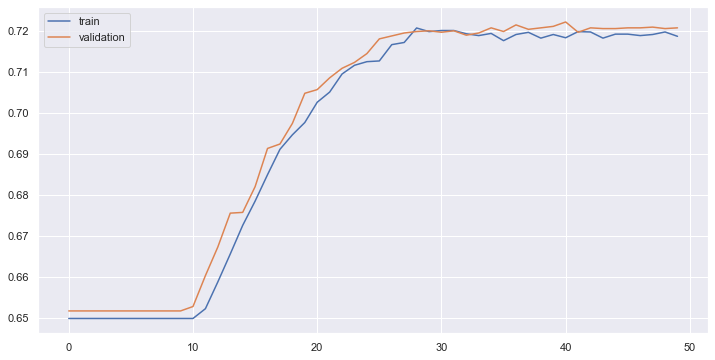

In [127]:
fig, ax = plt.subplots(figsize = (12,6))
plt.plot(model_outcome.history['accuracy'])
plt.plot(model_outcome.history['val_accuracy'])
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()

In [ ]:
sorted([(x, sys.getsizeof(globals().get(x))) 
        for x in dir() 
        if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], 
       key=lambda x: x[1], reverse=True)